# System Identification with the ``ssid`` package

In [1]:
import numpy as np
from utilities.printing import *
from utilities.testing import test_method
from utilities.config import Config
import ssid
from ssid import modes
from control.matlab import ss, lsim

## Define a SDOF system
parameter | value
----------|-------
m  | mass
k  | stiffness
c  | damping coefficient
nt | number of timesteps
dt | timestep

![sdof](./figures/sdof.png)

In [2]:
# parameters of SDOF system
mass = 1       # mass
k = 30         # stiffness
zeta = 0.01    # damping ratio
omega_n = np.sqrt(k/mass)  # natural frequency (rad/s)
Tn = 2*np.pi/omega_n  # natural periods (s)
c = 2*zeta*mass*omega_n    # damping coefficient
print(f"natural period: {Tn:<3.5}s")
print(f"damping ratio: {zeta}")

# forcing frequencies (rad/s)
omega_f = [0.017*omega_n, 0.14*omega_n, 0.3*omega_n]

natural period: 1.1471s
damping ratio: 0.01


In [3]:
# forcing function (input)
nt = 5000       # number of timesteps
dt = 0.03       # timestep
tf = nt*dt      # final time
t = np.arange(start = 0, stop = tf, step = dt)
f = np.sum(np.sin([omega*t for omega in omega_f]), axis=0)

In [4]:
# displacement response (analytical solution) (output)
omega_D = omega_n*np.sqrt(1-zeta**2)
y = np.zeros((3,nt))
for i,omega in enumerate(omega_f):
    C3 = (1/k)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C4 = -(2*zeta*omega/omega_n)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C1 = -C4
    C2 = (zeta*omega_n*C1-omega*C3)/omega_D
    y[i,:] = np.exp(-zeta*omega_n*t)*(C1*np.cos(omega_D*t)+C2*np.sin(omega_D*t)) + C3*np.sin(omega*t) + C4*np.cos(omega*t)
y = np.sum(y,axis=0)

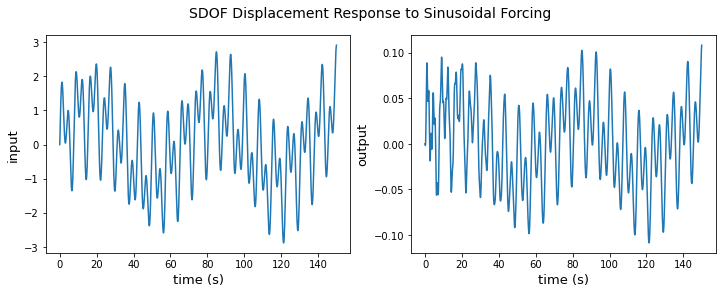

In [5]:
# plot input vs. output
plot_io(input=f, output=y, t=t, title="SDOF Displacement Response to Sinusoidal Forcing")

## Perform System Identification

In [6]:
# Generate a state space realization of the system
A,B,C,D = ssid.system(input=f, output=y)
# Obtain natural period and damping ratio from the state space model
ss_modes = modes.modes((A,B,C,D),dt)
print_modes(ss_modes, Tn=Tn, zeta=zeta)

Spectral quantities:
         T         ζ          T % error    ζ % error
      1.147      0.01         -2.323e-13    5.208e-11
      2.9        0.8643       152.8        8.543e+03
      0.05512    0.8956       -95.2        8.856e+03


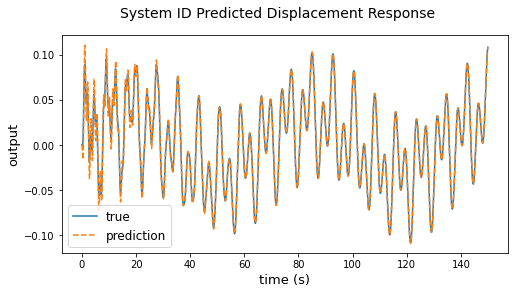

In [7]:
# Reproduce the response with the state space model
y_ssid = lsim(ss(A,B,C,D,dt),f,t)[0]
plot_pred(ytrue=y, models=y_ssid, t=t, title="System ID Predicted Displacement Response")

## Breakdown of System Identification Methods

### General Parameters
parameter | value
----------|-------
`p ` | number of output channels
`q ` | number of input channels
`nt` | number of timesteps
`dt` | timestep

### Specific to Observer Kalman Identification (OKID)
parameter | value
----------|-------
`m`  | number of Markov parameters to compute (at most = nt)

### Specific to Eigensystem Realization Algorithm (ERA)
parameter | value
----------|-------
`no` | number of observability parameters
`nc` | number of controllability parameters
`r ` | reduced model order

### Specific to Data Correlations (DC)
parameter | value
----------|-------
`a`  | (alpha) number of additional block rows in Hankel matrix of correlation matrices
`b`  | (beta) number of additional block columns in Hankel matrix of correlation matrices
`l`  | initial lag
`g`  | lag (gap) between correlations

### Specific to System Realization with Information Matrix (SRIM)
parameter | value
----------|-------
`no` | number of steps used for identification (prediction horizon)

### Method Inputs

In [8]:
# Set parameters
conf = Config()
conf.m  = 300
conf.no = 140
conf.nc = 140
conf.r  =   2
conf.a  =   0
conf.b  =   0
conf.l  =  10
conf.g  =   3

# A place to store models and their predictions
models = {}

### OKID-ERA

In [9]:
# OKID-ERA
method = "okid-era"
models[method] = test_method(method=method, input=f, output=y, dt=dt, t=t, **conf)
print_modes(models[method]["modes"], Tn=Tn, zeta=zeta)

Spectral quantities:
         T         ζ          T % error    ζ % error
      1.147      0.01043      0.01875      4.329    


### OKID-ERA-DC

In [10]:
# OKID-ERA-DC
method = "okid-era-dc"
models[method] = test_method(method=method, input=f, output=y, dt=dt, t=t, **conf)
print_modes(models[method]["modes"], Tn=Tn, zeta=zeta)

Spectral quantities:
         T         ζ          T % error    ζ % error
      1.147      0.009858     -0.003061    -1.419   


/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/modes.py:40: RuntimeWarning: invalid value encountered in true_divide
  damp = -np.real(Lam)/Omega


### SRIM

In [11]:
# SRIM
method = "srim"
models[method] = test_method(method=method, input=f, output=y, dt=dt, t=t, **conf)
print_modes(models[method]["modes"], Tn=Tn, zeta=zeta)

Spectral quantities:
         T         ζ          T % error    ζ % error
      1.147      0.01         -8.13e-13    -2.049e-11


### Compare Methods

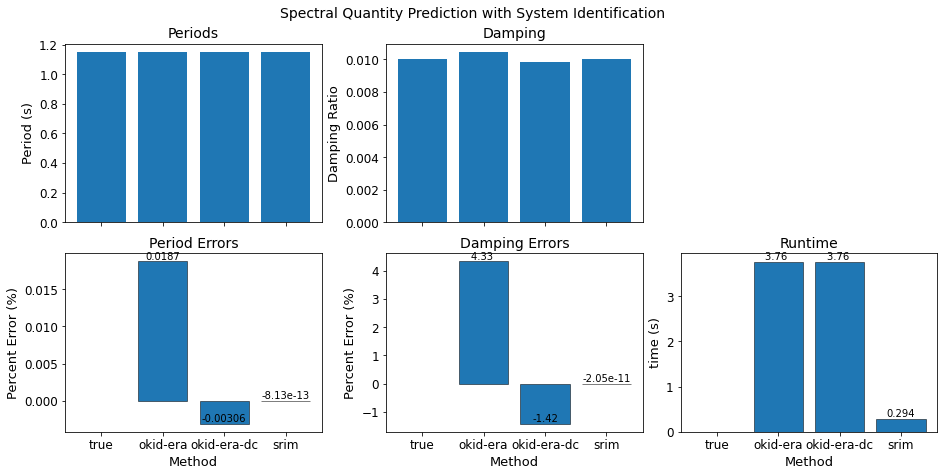

In [12]:
plot_models(models, Tn, zeta)

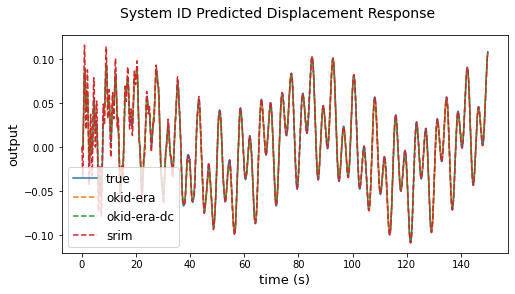

In [13]:
plot_pred(ytrue=y, models=models, t=t, title="System ID Predicted Displacement Response")